##### Coffee machine (H/W 4)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
##### Regulator block
N = 32
n = 1000
directions = np.tile([1, -1, -1, 1], n // 4)
cell_sizes = np.tile([2, 4, 2, 3], n // 4)
steps = np.tile([0, 1, 1, 0], n // 4)

tile_sizes = [4, 3, 2]
entropy_history = {size: [] for size in tile_sizes}

grid = np.zeros((N, N), dtype=float)
grid[:N//2, :] = 1.0  # Top half = coffee

grid

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(32, 32))

In [3]:
def rotate_block_clockwise(block):
    return np.rot90(block, k=-1)

def rotate_block_counterclock(block):
    return np.rot90(block, k=1)

def convection(grid, direction, cell_size, step):
    new_grid = grid.copy()
    for i in range(step, grid.shape[0], cell_size):
        for j in range(step, grid.shape[1], cell_size):
            block = grid[i:i+cell_size, j:j+cell_size]
            if block.shape == (cell_size, cell_size):  # ignore partial edge blocks
                rotated = np.rot90(block, k=direction)
                new_grid[i:i+cell_size, j:j+cell_size] = rotated
    return new_grid

def compute_local_entropy(grid, tile_size):
    H_list = []
    for i in range(0, grid.shape[0], tile_size):
        for j in range(0, grid.shape[1], tile_size):
            tile = grid[i:i+tile_size, j:j+tile_size]
            values, counts = np.unique(tile, return_counts=True)
            probs = counts / tile.size
            if len(probs) > 1:
                H = -np.sum(probs * np.log2(probs))
            else:
                H = 0.0
            H_list.append(H)
    return np.mean(H_list)

In [4]:
new_grid = grid.copy()
for i in range(n):
    new_grid = convection(new_grid, directions[i], cell_sizes[i], steps[i])
    # print(f"Step {i}")
    # print(new_grid)
    # print('===========')

In [5]:
import matplotlib.colors as mcolors
import matplotlib.animation as animation

cmap = mcolors.ListedColormap(["white", "saddlebrown"])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(grid, cmap=cmap, norm=norm)
text = ax.text(1, -2, "", ha="left", va="bottom", fontsize=12)
ax.set_xticks(np.arange(-0.5, N, 1), minor=True)
ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
ax.grid(which='minor', color='gray', linewidth=0.5)
ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

def update(frame):
    global grid
    grid = convection(grid, directions[frame], cell_sizes[frame], steps[frame])
    img.set_data(grid)
    text.set_text(f"Step: {frame}")

    for tile_size in tile_sizes:
        entropy = compute_local_entropy(grid, tile_size=tile_size)
        entropy_history[tile_size].append(entropy)

    return [img, text]

# --- Create and save animation
ani = animation.FuncAnimation(fig, update, frames=n, interval=150, blit=True)

ani.save("mixing_simulation.gif", writer="pillow", fps=6)
plt.close(fig)  # Close to avoid duplicate showing

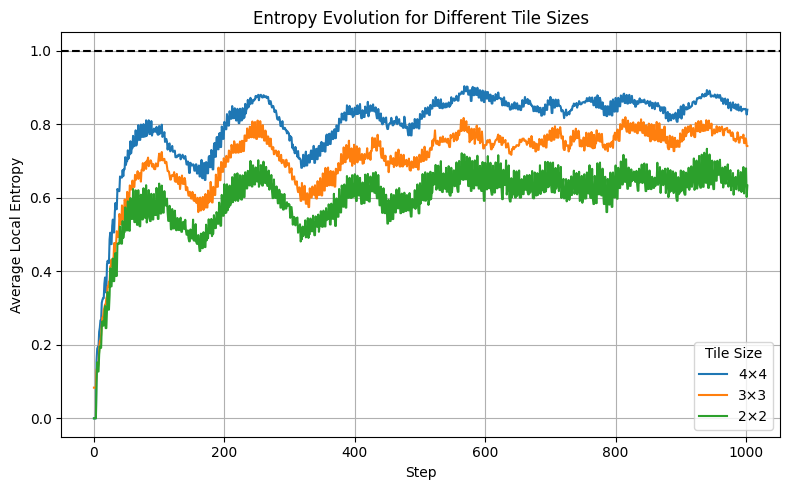

In [6]:
plt.figure(figsize=(8, 5))
for tile_size in tile_sizes:
    plt.plot(entropy_history[tile_size], label=f"{tile_size}×{tile_size}")
plt.xlabel("Step")
plt.ylabel("Average Local Entropy")
plt.title("Entropy Evolution for Different Tile Sizes")
plt.legend(title="Tile Size")
plt.grid(True)
plt.axhline(1.0, 0, 100, color='black', linestyle='dashed', label='maximum entropy (total chaos)')
plt.tight_layout()
plt.show()